<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/AllExtensions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 56.1 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time

# Example parameters
V = range(7)  # nodes including depot, 0 is depot
V_star = range(1, 7)  # nodes excluding depot
K = range(3)
Q = [25, 18, 20]
vehicle_speed = 60  # vehicle speed in km/h
fixed_costs = [110, 100, 105]  # fixed costs for each vehicle

# DISTANCES!
np.random.seed(42)
distances = np.random.randint(10, 51, size=(len(V), len(V)))
for i in V:
    distances[i, i] = 0
    for j in range(i + 1, len(V)):
        distances[j, i] = distances[i, j]
for i in V:
    for j in V:
        for k in V:
            if distances[i, j] > distances[i, k] + distances[k, j]:
                distances[i, j] = distances[i, k] + distances[k, j]

t = distances / vehicle_speed  # travel times
c = distances * 0.093  # travel costs (arbitrary scaling for fuel)

# Sample demands and pickup (including depot which has 0 demand)
d = [0, 50, 35, 20, 25, 30, 25]  # demands for each node
p = [0, 30, 22.5, 30, 45, 40, 28]  # pickup for each node

# Time window parameters
a = [0, 5, 10, 20, 20, 5, 10]  # Earliest arrival times
b = [30, 25, 35, 30, 30, 15, 25]  # Latest departure times
s = [0, 10, 10, 7, 5, 5, 10]  # Service times

# Model setup
model = gp.Model("All_VRPTW")

# Decision variables
x = model.addVars(V, V, K, vtype=GRB.BINARY, name="x")  # binary: whether vehicle k travels from i to j
q = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="q")  # continuous: cumulative demand on vehicle k at node i
tau = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="tau")  # continuous: arrival time of vehicle k at node i
# Add new continuous variable for load delivered to each node (y)
y = model.addVars(V_star, K, vtype=GRB.CONTINUOUS, name="y")
# Add new continuous variable for amount picked up by vehicle k at customer i (z)
z = model.addVars(V_star, K, vtype=GRB.CONTINUOUS, name="z")

'''
# Objective: Minimize total travel cost
model.setObjective(
    gp.quicksum(c[i, j] * x[i, j, k] for i in V for j in V for k in K if i != j) +
    gp.quicksum(fixed_costs[k] * gp.quicksum(x[0, j, k] for j in V_star) for k in K),
    GRB.MINIMIZE
)
'''
# Objective: Minimize total travel cost
model.setObjective(
    gp.quicksum(c[i, j] * x[i, j, k] for i in V for j in V for k in K if i != j) +
    gp.quicksum(fixed_costs[k] for k in K),
    GRB.MINIMIZE
)

# Constraints

# Constraint 1: each vehicle visited by at least one customer
model.addConstrs(
    (gp.quicksum(x[i, j, k] for i in V for k in K) >= 1 for j in V_star),
    name="visit_customer_once"
)

# Constraint 2: each vehicle departed from by at least one customer
model.addConstrs(
    (gp.quicksum(x[i, j, k] for j in V for k in K) >= 1 for i in V_star),
    name="departure_from_node_once"
)

# Constraint 3: Ensure each vehicle departs the depot at most once
model.addConstrs(
    (gp.quicksum(x[0, j, k] for j in V_star) == 1 for k in K),
    name="vehicle_depart_depot_once"
)

# Constraint 4: Ensure each vehicle returns to the depot at most once
model.addConstrs(
    (gp.quicksum(x[i, 0, k] for i in V_star) == 1 for k in K),
    name="vehicle_return_depot_once"
)

# Constraint 5: Flow Conservation
model.addConstrs(
    (gp.quicksum(x[i, j, k] for i in V if j != i) == gp.quicksum(x[j, i, k] for i in V if j != i)
    for j in V_star for k in K),
    name="flow_conservation"
)

# Constraint 6: No self-loops
model.addConstrs(
    (x[i, i, k] == 0 for i in V for k in K),
    name="no_self_loops"
)

# Constraint 7: Depot load initialization
model.addConstrs(
    (q[0, k] == 0 for k in K),
    name="depot_load"
)

# Constraint 8: q bound
model.addConstrs(
    (q[i, k] >= 0 for i in V_star for k in K),
    name="load_lower_bound"
)

model.addConstrs(
    (q[i, k] <= Q[k] for i in V_star for k in K),
    name="load_upper_bound"
)

# Constraint 9: y non-negative
model.addConstrs(
    (y[i, k] >= 0 for i in V_star for k in K),
    name="y_lower_bound"
)

# Constraint 10: z non-negative
model.addConstrs(
    (z[i, k] >= 0 for i in V_star for k in K),
    name="z_lower_bound"
)

# Constraint 11: Dropoff/Delivery feasibility
model.addConstrs(
    (y[j, k] <= q[i, k] + d[j] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="dropoff_feasibility"
)

# Constraint 12: Pickup Feasibility
model.addConstrs(
    (z[j, k] <= Q[k] - (q[i, k] - y[j, k]) + p[j] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="pickup_feasibility"
)

# Constraint 13: Delivery fulfillment and Pickup fulfillment
model.addConstrs(
    (gp.quicksum(y[i, k] for k in K) == d[i] for i in V_star),
    name="delivery_fulfillment"
)

model.addConstrs(
    (gp.quicksum(z[i, k] for k in K) == p[i] for i in V_star),  # Use 'p' for pickup demand
    name="pickup_fulfillment"
)

# Constraint 14: Load Progression 1
model.addConstrs(
    (q[i, k] - y[j, k] + z[j, k] <= q[j, k] + Q[k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_one"
)

# Constraint 15: Load Progression 2
M = {(j, k): d[j] + Q[k] for j in V_star for k in K}

model.addConstrs(
    (q[i, k] - y[j, k] + z[j, k] >= q[j, k] - M[j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_two"
)

# Constraint 16: Delivery and pickup can only happen if the node is visited
model.addConstrs(
    (y[j, k] <= d[j] * gp.quicksum(x[i, j, k] for i in V) for j in V_star for k in K),
    name="load_delivery_consistency"
)

model.addConstrs(
    (z[j, k] <= p[j] * gp.quicksum(x[i, j, k] for i in V) for j in V_star for k in K),
    name="load_pickup_consistency"
)

# Constraint 17 (unchanged): Time Window #1
model.addConstrs(
    (tau[0, k] == 0 for k in K),
    name="depot_time"
)

# Constraint 18 (unchanged): Time Window #2
model.addConstrs(
    (a[i] <= tau[i, k] for i in V_star for k in K),
    name="time_window_start"
)
model.addConstrs(
    (tau[i, k] <= b[i] for i in V_star for k in K),
    name="time_window_end"
)

# Constraint 19 (unchanged): Time Window #3
M_2 = {(i, j, k): b[i] - a[j] + s[i] + t[i, j] for i in V_star for j in V_star for k in K if i != j}
model.addConstrs(
    (tau[i, k] + s[i] + t[i, j] <= tau[j, k] + M_2[i, j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="service_time"
)

# Start the timer
start_time = time.time()

# Solve the model
model.optimize()

# End the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes and seconds
minutes, seconds = divmod(elapsed_time, 60)

# Print the time
print(f"Optimization completed in {int(minutes)} minutes and {seconds:.2f} seconds")

# Output results
if model.status == GRB.OPTIMAL:
    print("\n--- Decision Variable Values ---")
    print("Travel Decisions (x[i, j, k]):")
    for k in K:
        for i in V:
            for j in V:
                if x[i, j, k].x > 0.5:  # Print only active decisions
                    print(f"x[{i}, {j}, {k}] = {x[i, j, k].x:.2f}")

    print("\nLoad Deliveries (y[i, k]):")
    for k in K:
        for i in V_star:
            if y[i, k].x > 0:  # Print only non-zero deliveries
                print(f"y[{i}, {k}] = {y[i, k].x:.2f}")

    print("\nLoad Pickups (z[i, k]):")
    for k in K:
        for i in V_star:
            if z[i, k].x > 0:  # Print only non-zero pickups
                print(f"z[{i}, {k}] = {z[i, k].x:.2f}")

    print("\n--- Vehicle Routes and Load Deliveries ---")
    for k in K:
        # Route construction based on x[i, j, k]
        route = [0]  # Start at the depot
        visited_nodes = set(route)

        current_node = 0
        while True:
            found_next = False
            for j in V:
                if x[current_node, j, k].x > 0.5 and current_node != j and j not in visited_nodes:
                    route.append(j)
                    visited_nodes.add(j)
                    current_node = j
                    found_next = True
                    break
            if not found_next or current_node == 0:
                break

        # Include nodes with deliveries and pickups
        for i in V_star:
            if y[i, k].x > 0 and i not in route:
                route.insert(-1, i)
            if z[i, k].x > 0 and i not in route:
                route.insert(-1, i)

        # Ensure the route ends at the depot
        if route[-1] != 0:
            route.append(0)

        # Print the route
        print(f"Vehicle {k} route: {' -> '.join(map(str, route))}")
        total_cost = sum(c[route[i], route[i + 1]] for i in range(len(route) - 1))
        print(f"Total cost for Vehicle {k}: {total_cost:.2f}")

        # Print loads delivered by the vehicle
        print(f"Loads delivered by Vehicle {k}:")
        for i in V_star:
            if y[i, k].x > 0:  # Check if the vehicle delivered to this node
                print(f"  Node {i}: {y[i, k].x:.2f} units")

        # Print loads picked up by the vehicle
        print(f"Loads picked up by Vehicle {k}:")
        for i in V_star:
            if z[i, k].x > 0:  # Check if the vehicle picked up at this node
                print(f"  Node {i}: {z[i, k].x:.2f} units")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 669 rows, 225 columns and 2763 nonzeros
Model fingerprint: 0xc362c0db
Variable types: 78 continuous, 147 integer (147 binary)
Coefficient statistics:
  Matrix range     [5e-01, 8e+01]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 307 rows and 57 columns
Presolve time: 0.02s
Presolved: 362 rows, 168 columns, 1840 nonzeros
Variable types: 69 continuous, 99 integer (99 binary)

Root relaxation: objective 3.377603e+02, 155 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  337.76032    0   18          -  337.76

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_routes(V, V_star, K, distances, x, y, z, q, fixed_costs, d, p):
    # Create the graph
    G = nx.DiGraph()

    # Add nodes
    for i in V:
        G.add_node(i, demand=d[i], pickup=p[i])

    # Add edges for all vehicles
    edge_colors = ['red', 'blue', 'green']
    for k in K:
        for i in V:
            for j in V:
                if i != j and x[i, j, k].x > 0.5:
                    G.add_edge(i, j, vehicle=k, weight=distances[i][j])

    # Node positions (circle layout)
    pos = nx.circular_layout(G)

    # Draw nodes
    node_colors = ['orange' if i == 0 else 'lightblue' for i in V]
    node_labels = {i: f"{i}\n D: {d[i]}, P: {p[i]}" for i in V}
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    # Draw edges with multiple colors if they share the same edge
    for i, j in G.edges:
        vehicles_on_edge = [k for k in K if x[i, j, k].x > 0.5]
        for idx, k in enumerate(vehicles_on_edge):
            # Offset the edge slightly for each vehicle to distinguish them
            offset = 0.03 * idx  # Adjust offset as needed for better clarity
            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(i, j)],
                edge_color=[edge_colors[k]],
                width=2,
                alpha=0.8,
                connectionstyle=f'arc3,rad={offset}',  # Create slight arcs for overlapping edges
                label=f"Vehicle {k}" if idx == 0 else None  # Avoid duplicate labels
            )

    # Add delivery and pickup amounts next to nodes with spacing
    for i in V_star:
        info = []
        for k in K:
            if y[i, k].x > 0:  # Check if there's delivery to the node
                info.append(f"Delivery V{k}: {y[i, k].x}")
            if z[i, k].x > 0:  # Check if there's pickup from the node
                info.append(f"Pickup V{k}: {z[i, k].x}")

        # Add spaced text with a box near the node
        for idx, detail in enumerate(info):
            x_offset, y_offset = 0.1, 0.1 + idx * 0.1  # Adjust vertical spacing for multiple entries
            plt.text(
                pos[i][0] + x_offset,
                pos[i][1] + y_offset,
                detail,
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.3')  # Box style
            )

    # Create a legend for vehicle routes
    legend_elements = [Line2D([0], [0], color=edge_colors[k], lw=2, label=f'V {k}') for k in K]
    plt.legend(handles=legend_elements, loc='lower left')

    plt.axis('off')  # Hide axes
    plt.title("")
    plt.show()

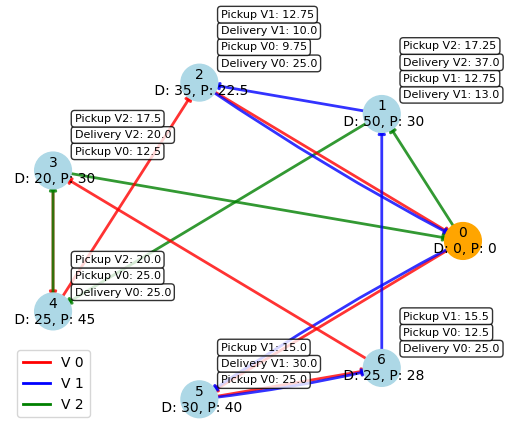

In [ ]:
visualize_routes(V, V_star, K, distances, x, y, z, q, fixed_costs, d, p)